### The purpose of this notebook is to run multiple experiments

In [1]:
from basket_util import *

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import math
from datetime import datetime, timedelta
import collections

import plotly as py
import plotly.express as px
import plotly.offline as pyo
from plotly.offline import iplot, plot, init_notebook_mode, download_plotlyjs
import plotly.graph_objs as go
init_notebook_mode(connected=True)

from pySankey.sankey import sankey

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import association_rules
from mlxtend.frequent_patterns import fpgrowth

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score


import warnings
warnings.filterwarnings('ignore')


* preparing basket data using the new basket data file
* old data file is 'new_baskets_full.csv' for a different supplier that we can use for comparison

In [83]:
dropna = True
datecol = 'placed_at'
filename = 'new_baskets_adhie.csv'

baskets = prep_data(filename, dropna,datecol)
baskets = baskets[baskets.merchant_id !=190]
baskets = baskets[baskets.merchant_id !=12]
baskets = baskets[baskets.merchant_id !=206]
baskets = baskets[baskets.date >=  pd.to_datetime('2021-09-27').date()]
#baskets = baskets[baskets.top_cat_id !=  27]

In [84]:

merchant_attributes = get_merchant_attributes(baskets)
sku_attributes = get_sku_attributes(baskets)
order_attributes = get_order_attributes(baskets)

sku_by_day = get_skus_by_day(baskets)
top_cats = make_top_cats(baskets)

* preparing data for clustering

In [86]:
merchant_topcat = pd.pivot_table(
    baskets,
    index='merchant_id',   # Column to turn into new index
    columns='top_cat_id',  # Column to turn into new columns
    values=['order_id', 'qty', 'spent'], # Column to aggregate for values
    aggfunc={'order_id': 'nunique', 'qty':sum, 'spent':sum},  # Aggregation function
    fill_value= 0,
)
merchant_topcat.columns = [f'{x}_{y}' for x,y in merchant_topcat.columns]

df1 = pd.pivot_table(
    baskets,
    index='merchant_id',   # Column to turn into new index
    columns='top_cat_id',  # Column to turn into new columns
    values='order_id', # Column to aggregate for values
    aggfunc="nunique",    # Aggregation function
    fill_value= 0,
)

df2 = pd.pivot_table(
    baskets,
    index='merchant_id',   # Column to turn into new index
    columns='top_cat_id',  # Column to turn into new columns
    values='spent', # Column to aggregate for values
    aggfunc="sum",    # Aggregation function
    fill_value= 0,
)


In [54]:
cols = []
for i in list(merchant_topcat.columns):
    cols.append('_'.join(map(str, i)))

merchant_topcat = merchant_topcat.rename(mapper = dict(zip(merchant_topcat.columns,cols)) )

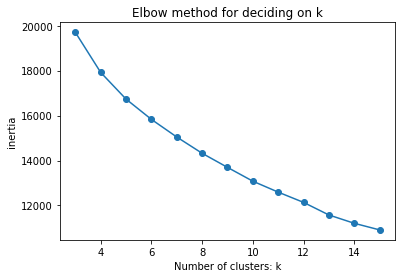

In [68]:
colnames = merchant_topcat.columns
clusters_range = [3,4,5,6,7,8,9,10,11,12,13,14,15]
find_elbow(merchant_topcat, colnames,clusters_range)

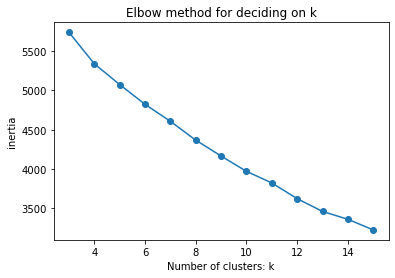

In [87]:
colnames = df1.columns
clusters_range = [3,4,5,6,7,8,9,10,11,12,13,14,15]
find_elbow(df1, colnames,clusters_range)

In [104]:
columns = df1.columns
k = 6
df1_kmeans = run_kmeans(df1, colnames,k)
df_for_cluster = df1.loc[:,colnames]
stscaler = StandardScaler().fit(df_for_cluster)
normalized_df = stscaler.transform(df_for_cluster)
silhouette_avg = silhouette_score(normalized_df, df1_kmeans.cluster)

df1_kmeans.groupby('cluster').size(), silhouette_avg


(cluster
 0    178
 1     16
 2     54
 3      7
 4     66
 5      4
 dtype: int64,
 0.4026086816033614)

In [69]:
colnames = merchant_topcat.columns
df_for_cluster = merchant_topcat.loc[:,colnames]
stscaler = StandardScaler().fit(df_for_cluster)
normalized_df = stscaler.transform(df_for_cluster)

For n_clusters = 3 The average silhouette_score is : 0.436034694306848
For n_clusters = 4 The average silhouette_score is : 0.41702845434348523
For n_clusters = 5 The average silhouette_score is : 0.4175976692819866
For n_clusters = 6 The average silhouette_score is : 0.38838194093141365
For n_clusters = 7 The average silhouette_score is : 0.39694015798879667
For n_clusters = 8 The average silhouette_score is : 0.41583818123475497
For n_clusters = 9 The average silhouette_score is : 0.3523160087290097
For n_clusters = 10 The average silhouette_score is : 0.4044929903981404


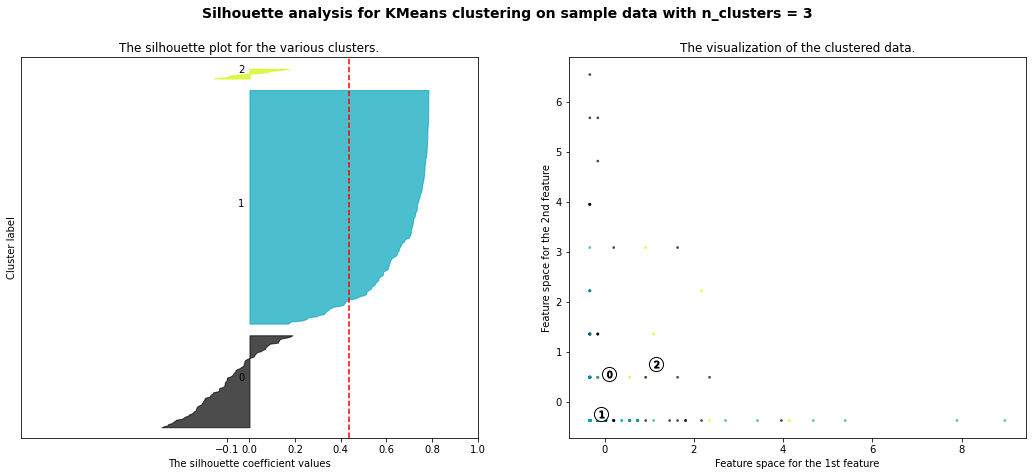

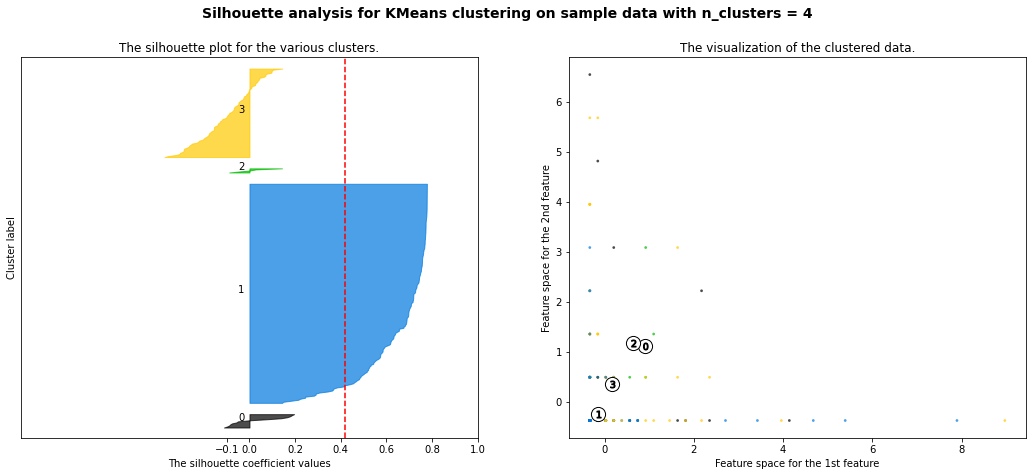

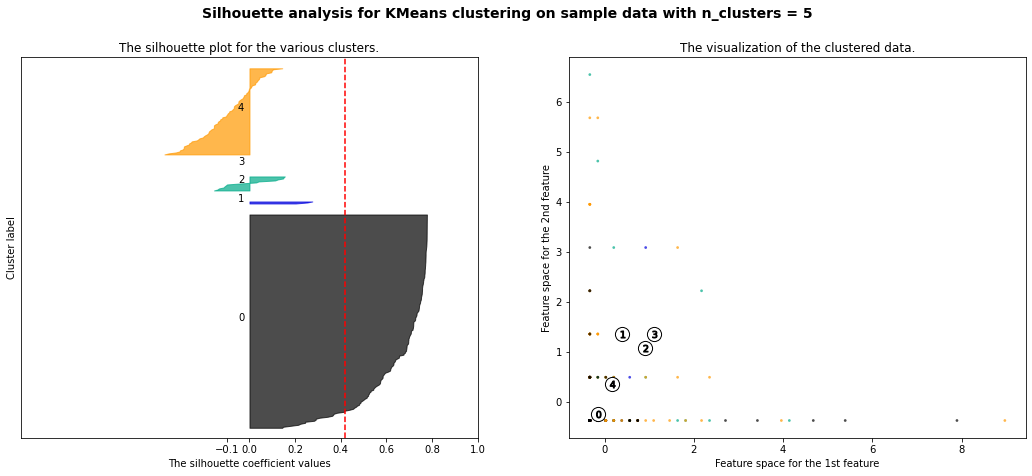

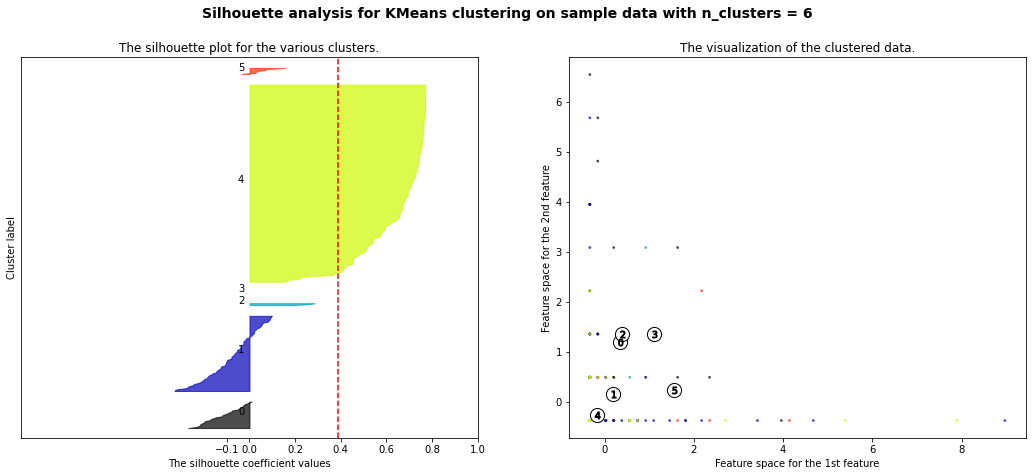

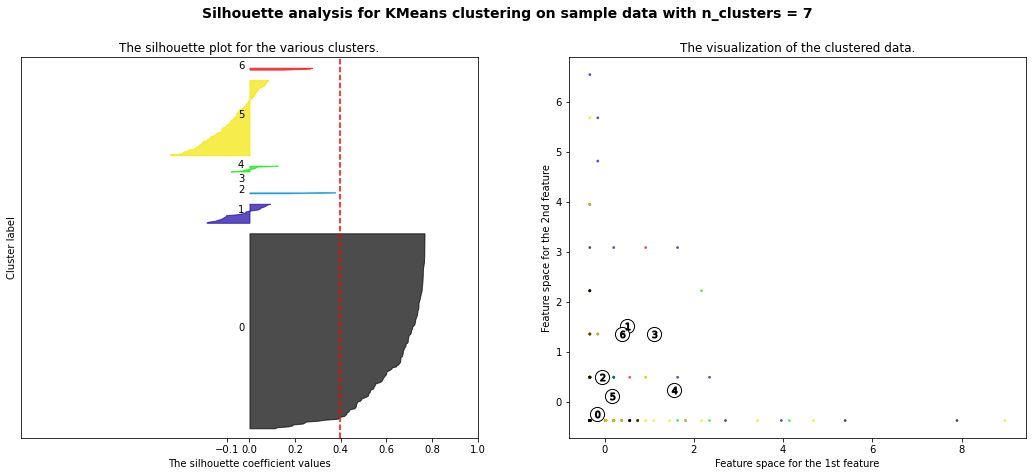

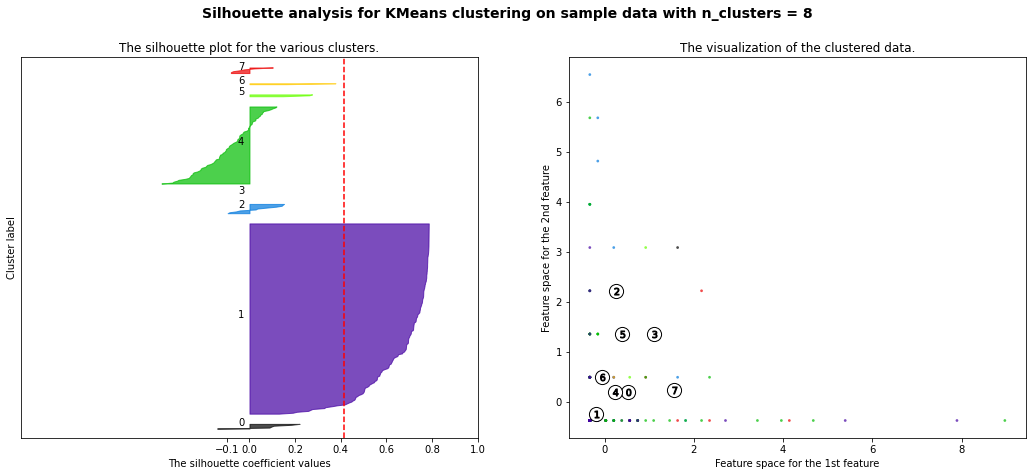

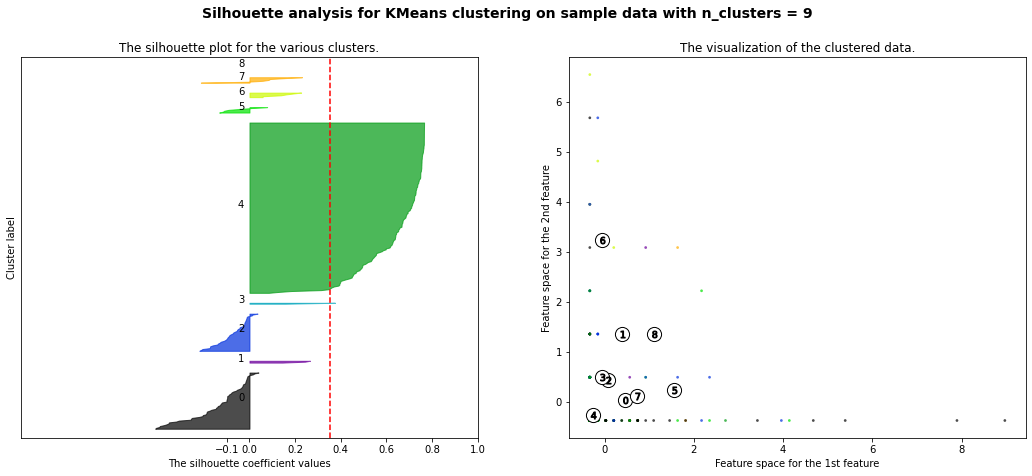

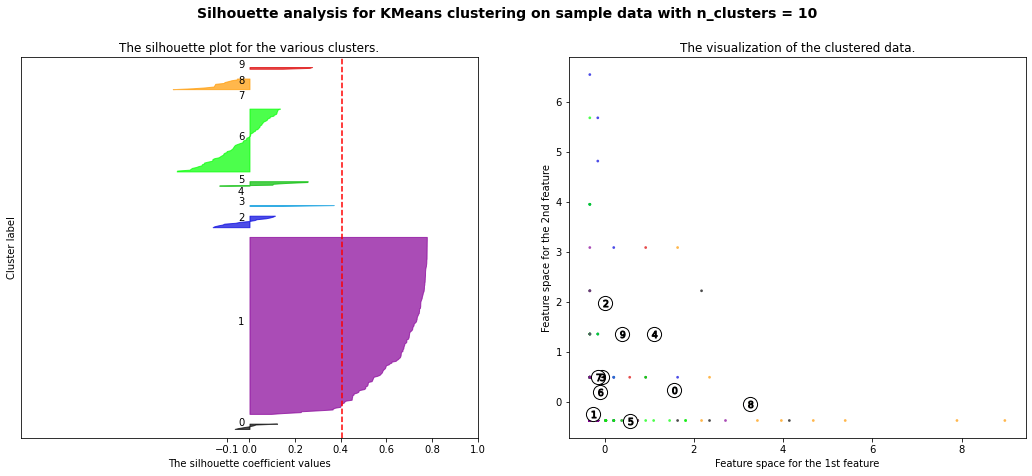

In [70]:
range_n_clusters = [3, 4, 5, 6, 7, 8, 9, 10]

for n_clusters in range_n_clusters:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    ax1.set_xlim([-1, 1])
    ax1.set_ylim([0, len(normalized_df) + (n_clusters + 1) * 10])

    clusterer = KMeans(n_clusters=n_clusters, random_state=0)
    cluster_labels = clusterer.fit_predict(normalized_df)
    silhouette_avg = silhouette_score(normalized_df, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(normalized_df, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        normalized_df[:, 0], normalized_df[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

In [89]:
columns = df1.columns
k = 6
df1_kmeans = run_kmeans(df1, colnames,k)
df1_kmeans.groupby('cluster').size()

cluster
0     53
1    178
2      8
3     16
4      4
5     66
dtype: int64

In [90]:
df1_results = df1_kmeans.groupby("cluster").mean().reset_index()

In [91]:
df1_results = df1_results.melt(id_vars="cluster")

<AxesSubplot:xlabel='top_cat_id', ylabel='value'>

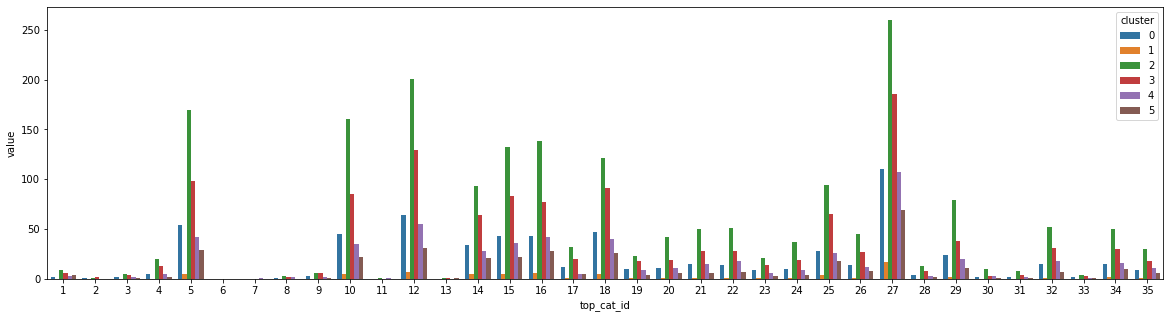

In [92]:
plt.figure(figsize=(20,5))
sns.barplot(data=df1_results,x="top_cat_id",y="value", hue = "cluster")

In [93]:
df1_results_pivot = pd.pivot_table(
    df1_results,
    index='top_cat_id',   # Column to turn into new index
    columns='cluster',  # Column to turn into new columns
    values='value', # Column to aggregate for values
    aggfunc="sum")    # Aggregation function
df1_results_pivot

cluster,0,1,2,3,4,5
top_cat_id,,,,,,
1,1.622642,0.348315,9.375,5.8125,2.50,4.090909
2,1.000000,0.089888,0.875,2.2500,0.25,0.378788
3,1.811321,0.213483,4.875,3.7500,1.75,1.212121
4,5.075472,0.365169,19.750,12.8750,4.50,1.787879
5,54.094340,5.331461,169.500,98.3750,42.25,29.333333
6,0.018868,0.005618,0.125,0.1875,0.00,0.030303
7,0.000000,0.000000,0.125,0.0000,1.00,0.000000
8,0.547170,0.022472,2.500,1.9375,1.75,0.348485
9,2.641509,0.157303,5.500,5.9375,1.75,1.348485


In [94]:
(df1_kmeans.query('cluster ==4'))

top_cat_id,1,2,3,4,5,6,7,8,9,10,...,27,28,29,30,31,32,33,34,35,cluster
merchant_id,,,,,,,,,,,,,,,,,,,,,
11,1,1,2,2,26,0,1,0,2,46,...,162,0,10,3,4,17,0,21,10,4
36,1,0,3,1,58,0,1,1,2,50,...,125,3,22,0,1,30,1,17,11,4
53,2,0,2,5,58,0,1,0,2,25,...,95,8,38,7,1,14,1,19,17,4
115,6,0,0,10,27,0,1,6,1,18,...,47,1,9,0,2,9,2,7,4,4


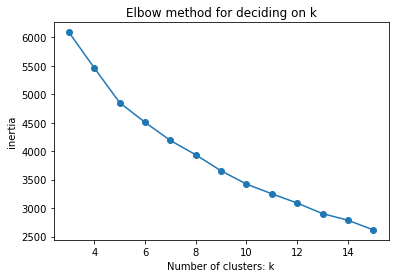

In [95]:
colnames = df2.columns
clusters_range = [3,4,5,6,7,8,9,10,11,12,13,14,15]
find_elbow(df2, colnames,clusters_range)

In [100]:
colnames = df2.columns
k = 6
df2_kmeans = run_kmeans(df2, colnames,k)
df2_kmeans.groupby("cluster").size()


cluster
0      1
1    221
2     11
3      1
4     88
5      3
dtype: int64

In [102]:
(df2.query('cluster ==0 or cluster==3'))

top_cat_id,1,2,3,4,5,6,7,8,9,10,...,27,28,29,30,31,32,33,34,35,cluster
merchant_id,,,,,,,,,,,,,,,,,,,,,
51,1537000,510000,1271000,4596000,123442100,0,62000,0,350000,112835000,...,875467900,2040000,23697000,1598000,993000,11291000.0,0,46006500,4462300,3
205,2180000,0,250000,0,10295000,0,0,0,0,1736000,...,2441519050,105000,0,0,4251000,405000.0,0,1503000,0,0


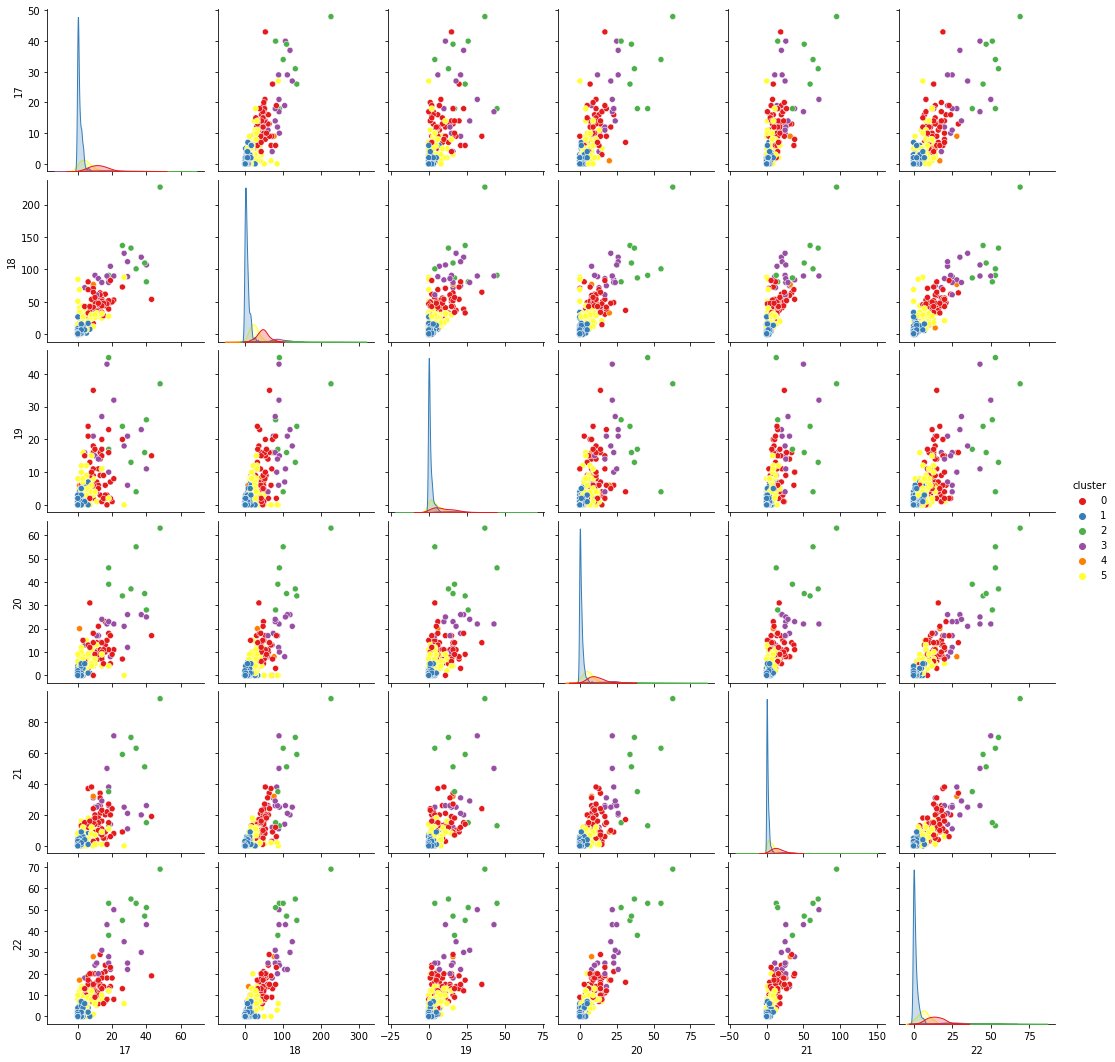

In [103]:
sns.pairplot(data=df1_kmeans[["cluster",17,18,19,20,21,22]], hue="cluster", palette="Set1")


 - this can be a good way to represent month and week for easy printing and use in axes for plotting

In [22]:
baskets.placed_at.apply(lambda t: t.strftime("%Y-%W"))

28813     2021-39
28814     2021-39
28815     2021-39
28818     2021-39
28819     2021-39
           ...   
392936    2022-39
392937    2022-39
392938    2022-39
392939    2022-39
392940    2022-39
Name: placed_at, Length: 138169, dtype: object

In [23]:
baskets[baskets.month1 == "2022-01"]

,id,order_id,placed_at,merchant_id,sku_id,top_cat_id,sub_cat_id,qty,price,date,year,month,month1,month_num,week_num,week1,day,hour,weekday,spent
118557,118583,11167,2022-01-02 08:46:08.894,113,1399,18,65,2,20000.0,2022-01-02,2022,1,2022-01,13,52,2022-00,2,8,6,40000.0
118561,118587,11167,2022-01-02 08:46:08.894,113,711,34,100,5,10500.0,2022-01-02,2022,1,2022-01,13,52,2022-00,2,8,6,52500.0
118564,118590,11167,2022-01-02 08:46:08.894,113,916,12,86,1,268000.0,2022-01-02,2022,1,2022-01,13,52,2022-00,2,8,6,268000.0
118566,118592,11167,2022-01-02 08:46:08.894,113,1038,16,34,1,114000.0,2022-01-02,2022,1,2022-01,13,52,2022-00,2,8,6,114000.0
118567,118593,11167,2022-01-02 08:46:08.894,113,745,15,94,1,163000.0,2022-01-02,2022,1,2022-01,13,52,2022-00,2,8,6,163000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150049,150057,14153,2022-01-31 16:49:24.543,148,1598,5,6,1,105000.0,2022-01-31,2022,1,2022-01,13,57,2022-05,31,16,0,105000.0
150050,150058,14153,2022-01-31 16:49:24.543,148,1185,30,6,1,56000.0,2022-01-31,2022,1,2022-01,13,57,2022-05,31,16,0,56000.0
150051,150059,14153,2022-01-31 16:49:24.543,148,1140,15,50,3,118000.0,2022-01-31,2022,1,2022-01,13,57,2022-05,31,16,0,354000.0
150052,150060,14153,2022-01-31 16:49:24.543,148,1430,29,18,1,99000.0,2022-01-31,2022,1,2022-01,13,57,2022-05,31,16,0,99000.0


In [24]:
df1_out = df1_kmeans.reset_index()
df1_unpivoted = df1_out.melt(id_vars = ['merchant_id'], var_name='top_cat_id', value_name='order_id')

In [25]:
df1_unpivoted

,merchant_id,top_cat_id,order_id
0,1,1,0.0
1,2,1,1.0
2,3,1,0.0
3,4,1,0.0
4,5,1,0.0
...,...,...,...
11195,325,cluster,5.0
11196,326,cluster,5.0
11197,327,cluster,5.0
11198,328,cluster,5.0


In [26]:
plt.figure(figsize=(8,5))
sns.boxplot(x='class',y='age',data=titanic, palette='rainbow')
plt.title("Age by Passenger Class, Titanic")

NameError: name 'titanic' is not defined

<Figure size 576x360 with 0 Axes>

<AxesSubplot:xlabel='num_skus', ylabel='Density'>

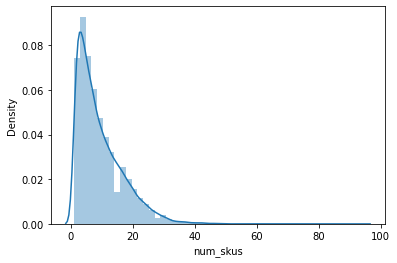

In [27]:
sns.distplot(order_attributes.num_skus)


In [28]:
(order_attributes.num_skus==1).sum()/order_attributes.shape[0]

0.04631923234169452

In [29]:
((order_attributes.total_spent.apply(lambda x: math.log(x,2))>25) | \
(order_attributes.total_spent.apply(lambda x: math.log(x,2))<15) ).sum()/order_attributes.shape[0]

0.0024530434573483083

In [30]:
order_attributes[(order_attributes.total_spent.apply(lambda x: math.log(x,2))>25) | \
(order_attributes.total_spent.apply(lambda x: math.log(x,2))<15)].head(100)

,order_id,total_spent,num_skus,num_top_cats,num_sub_cats
189,190,16100.0,1,1,1
430,431,17700.0,1,1,1
696,697,17800.0,1,1,1
723,724,17800.0,1,1,1
758,759,32000.0,1,1,1
...,...,...,...,...,...
39376,39379,16500.0,1,1,1
40129,40132,24000.0,1,1,1
40282,40285,47647000.0,14,5,3
40501,40504,32000.0,1,1,1


In [31]:
order_attributes[(order_attributes.total_spent.apply(lambda x: math.log(x,2))>25) | \
(order_attributes.total_spent.apply(lambda x: math.log(x,2))<15)].head(100)

,order_id,total_spent,num_skus,num_top_cats,num_sub_cats
189,190,16100.0,1,1,1
430,431,17700.0,1,1,1
696,697,17800.0,1,1,1
723,724,17800.0,1,1,1
758,759,32000.0,1,1,1
...,...,...,...,...,...
39376,39379,16500.0,1,1,1
40129,40132,24000.0,1,1,1
40282,40285,47647000.0,14,5,3
40501,40504,32000.0,1,1,1


In [32]:
392810/41581

9.446862749813617

In [33]:
pd.set_option('display.max_rows', 100)
print(baskets.groupby("week_num").merchant_id.nunique())

week_num
39    109
40    159
41    145
42    135
43    129
44    133
45    139
46    123
47    118
48    128
49    130
50    134
51    129
52    133
53    143
54    151
55    142
56    141
57    143
58    152
59    132
60    143
61    140
62    141
63    131
64    141
65    148
66    128
67    127
68    146
69    114
70     59
71    124
72    133
73    134
74    140
75    123
76    131
77    129
78    139
79    124
80    135
81    134
82    131
83    124
84    134
85    138
86    138
87    136
88    130
89    133
90    150
91    130
Name: merchant_id, dtype: int64


In [34]:
baskets[baskets["week_num"] < 39].groupby("merchant_id").nunique()

,id,order_id,placed_at,sku_id,top_cat_id,sub_cat_id,qty,price,date,year,month,month1,month_num,week_num,week1,day,hour,weekday,spent
merchant_id,,,,,,,,,,,,,,,,,,,


for weekly analysis, to make the work meaningful, we should use data from week 39 and onwards
for monthly analysis, to make the work meaningful, we should use the data from month October 2021 to Sepetember 2022.

In [35]:
sku_attributes.groupby("tenure_month").count()

,sku_id,total_spent,num_orders,num_merchants,first_month,last_month,num_months,first_week,last_week,num_weeks,num_days,avg_spent_per_order
tenure_month,,,,,,,,,,,,
1,55,55,55,55,55,55,55,55,55,55,55,55
2,55,55,55,55,55,55,55,55,55,55,55,55
3,51,51,51,51,51,51,51,51,51,51,51,51
4,172,172,172,172,172,172,172,172,172,172,172,172
5,416,416,416,416,416,416,416,416,416,416,416,416
6,19,19,19,19,19,19,19,19,19,19,19,19
7,27,27,27,27,27,27,27,27,27,27,27,27
8,27,27,27,27,27,27,27,27,27,27,27,27
9,36,36,36,36,36,36,36,36,36,36,36,36


In [36]:
sku_attributes.shape

(1800, 13)

In [37]:
print(sku_attributes.groupby("first_week").sku_id.nunique())

first_week
24     29
25    292
26    206
27     23
28     30
29      7
30     10
31      6
32      5
33      2
34      4
35      4
36      1
37     14
38      3
39      5
40     10
41    503
42    293
43    108
44     44
45     28
46     14
47     17
48     14
49     12
50      5
51      6
52      7
53      4
54      6
55      8
56      5
57      1
58      2
59      1
60      6
61      5
62      2
63      5
64      3
66      5
67      2
68      2
69      1
71      5
72      1
73      2
74      1
75      1
76      3
77      4
78      9
79      4
80      2
81      1
82      1
83      2
84      3
87      1
Name: sku_id, dtype: int64


In [38]:
fig = px.parallel_coordinates(sku_attributes[["first_month","sku_id","last_month","tenure_month"]], \
        color="tenure_month", labels={"sku_id": "sku ID",
                "first_month": "First Month", "last_month": "Last Month", },)
                             #color_continuous_scale=px.colors.diverging.Tealrose,
                            # color_continuous_midpoint=2)
fig.show()

<Figure size 6000x3000 with 0 Axes>

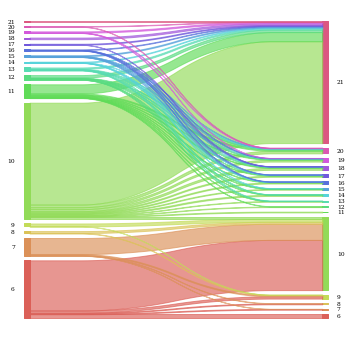

In [39]:
plt.figure(figsize=(30, 15), dpi=200)
df = sku_attributes.groupby(["first_month","last_month"]).sku_id.nunique().reset_index()
sankey(
    left=df["first_month"], right=df["last_month"],
    leftWeight= df["sku_id"], rightWeight=df["sku_id"], 
    aspect=20, fontsize=6
)

In [40]:
fig = px.parallel_coordinates(merchants[["first_month","merchant_id","last_month","tenure_month"]], \
        color="tenure_month", labels={"merchant_id": "merchant ID",
                "first_month": "First Month", "last_month": "Last Month", },)
                             #color_continuous_scale=px.colors.diverging.Tealrose,
                            # color_continuous_midpoint=2)
fig.show()

In [41]:
merchants[merchants.merchant_id==11]

,merchant_id,total_spent,num_orders,first_month,last_month,num_months,num_weeks,num_days,num_skus,num_top_cats,num_sub_cats,avg_spent_per_order,tenure_month
10,11,3.553156e+09,3236,6,20,7,21,117,663,33,81,1.098009e+06,15


In [42]:
(baskets.query('merchant_id ==11').query('month_num == 20'))


,id,order_id,placed_at,merchant_id,sku_id,top_cat_id,sub_cat_id,qty,price,date,year,month,month1,month_num,week_num,week1,day,hour,weekday,spent
350144,350165,36455,2022-08-22 13:44:40.652,11,1133,16,50,1,55000.0,2022-08-22,2022,8,2022-08,20,86,2022-34,22,13,0,55000.0
350145,350166,36455,2022-08-22 13:44:40.652,11,920,16,86,1,59500.0,2022-08-22,2022,8,2022-08,20,86,2022-34,22,13,0,59500.0


In [ ]:
1133 => 967056
920 ==>966689

<Figure size 6000x3000 with 0 Axes>

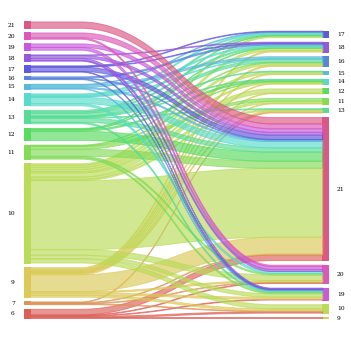

In [44]:
plt.figure(figsize=(30, 15), dpi=200)
df = merchants.groupby(["first_month","last_month"]).merchant_id.nunique().reset_index()
sankey(
    left=df["first_month"], right=df["last_month"],
    leftWeight= df["merchant_id"], rightWeight=df["merchant_id"], 
    aspect=20, fontsize=6
)

<AxesSubplot:>

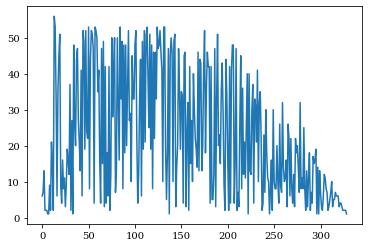

In [45]:
merchants.num_weeks.plot()

In [46]:
def count_unique(s):
    return len(s.unique())

sku_frequency = (baskets
    .groupby('sku_id')
    ['order_id']
 .agg(count_unique) # aggregate using the custom count_unique function
 .reset_index()
)


In [47]:
sku_frequency.head()
px.line(sku_attributes.num_orders)

In [48]:
sum(sku_frequency.order_id>50)

543

In [49]:
px.line(sku_frequency.sort_values("order_id", ascending = False).reset_index().order_id)


In [51]:
sku_frequency.sort_values("order_id",ascending=False)

,sku_id,order_id
1049,1327,2607
1339,1638,2516
673,873,2162
807,1044,1902
804,1041,1756
...,...,...
460,611,1
462,614,1
463,615,1
90,160,1


<AxesSubplot:>

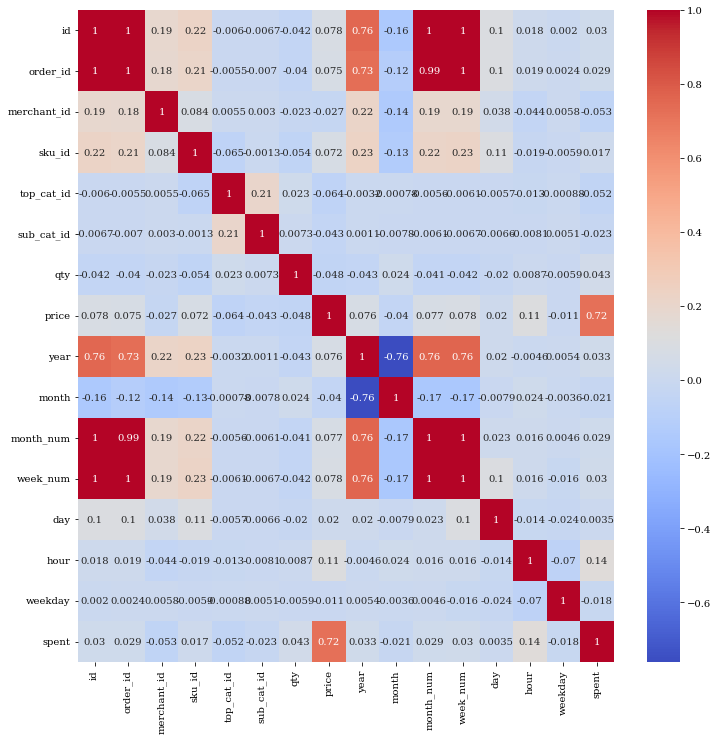

In [52]:
plt.figure(figsize=(12,12)) 
sns.heatmap(baskets.corr(),annot=True, cmap='coolwarm')

<AxesSubplot:>

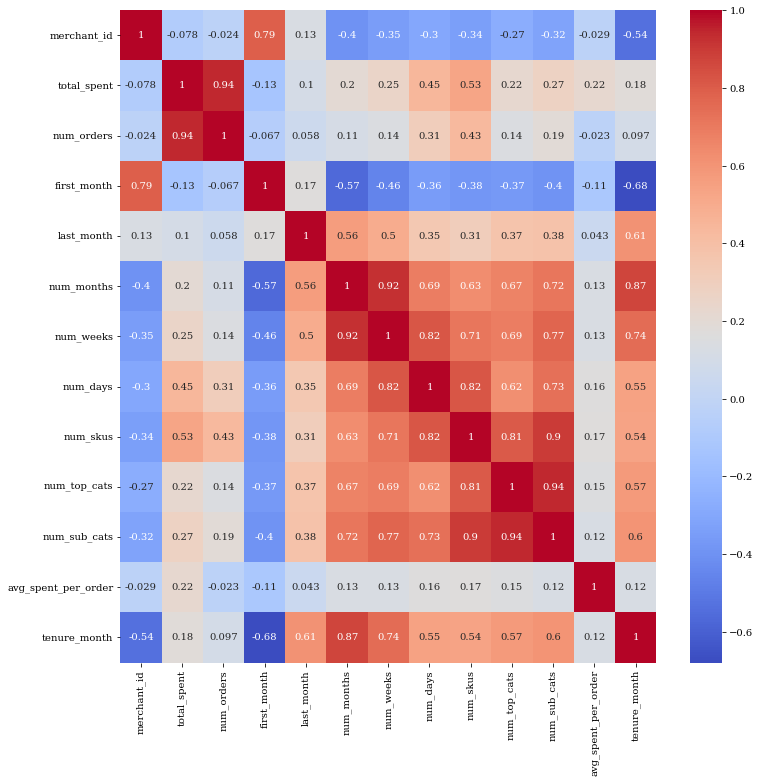

In [57]:
plt.figure(figsize=(12,12)) 
sns.heatmap(merchants.corr(),annot=True, cmap='coolwarm')

In [60]:
px.line(pd.crosstab(baskets['week_num'], baskets['top_cat_id']),width=1000,height=800)

In [61]:
df = baskets
df.groupby('order_id').all()

,id,placed_at,merchant_id,sku_id,top_cat_id,sub_cat_id,qty,price,date,year,month,month1,month_num,week_num,week1,day,hour,weekday,spent
order_id,,,,,,,,,,,,,,,,,,,
690,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
1164,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
3139,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False,True
3140,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False,True
3141,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41578,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
41579,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
41582,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True


In [62]:
transaction_data = []
for groups in df.groupby('order_id').groups.values():
    transaction_data.append(list(df.loc[groups]['sku_id'].to_numpy()))

In [63]:
transaction_data[0]

[456, 419, 457, 470, 591, 35]

In [64]:
def oneHotCoding(transaction_data):
    te = TransactionEncoder()
    te_ary = te.fit(transaction_data).transform(transaction_data)
    transaction_df = pd.DataFrame(te_ary, columns=te.columns_)
    return transaction_df

transaction_sku_data = oneHotCoding(transaction_data)

In [66]:
transaction_sku_data

,32,33,34,35,36,37,38,39,40,41,...,1788,1789,1790,1793,1794,1795,1797,1798,1799,1800
0,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19241,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
19242,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
19243,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
19244,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [67]:
def frq_sku_itemsets(data,suppVar):
    min_support = suppVar/data.shape[0]
    frequent_itemsets = fpgrowth(data, min_support=min_support, use_colnames=True)
    return frequent_itemsets

freq_itemsets = frq_sku_itemsets(transaction_sku_data,30)

In [68]:
freq_itemsets.tail()

,support,itemsets
3600,0.001974,"(1748, 1710)"
3601,0.002494,"(1748, 919)"
3602,0.001767,"(1748, 836)"
3603,0.002442,"(873, 1748)"
3604,0.002806,"(1748, 1327)"


In [69]:
# compute and print the association rules

def basket_rules(freq_itemsets,metrics,threshold):
    asso_rules = association_rules(freq_itemsets, metric=metrics, min_threshold=threshold)
    return asso_rules.sort_values(by='lift', ascending=False)[['antecedents', 'consequents', 'support', 'confidence', 'lift']]

fp_rules = basket_rules(freq_itemsets,"confidence",0.10)
fp_rules.head(60)

,antecedents,consequents,support,confidence,lift
2964,"(660, 1007)","(657, 1134)",0.001663,0.372093,121.378006
2961,"(657, 1134)","(660, 1007)",0.001663,0.542373,121.378006
3226,"(1163, 1134)","(1085, 1007)",0.001559,0.422535,117.856705
3229,"(1085, 1007)","(1163, 1134)",0.001559,0.434783,117.856705
882,"(1163, 1007)","(657, 853)",0.001663,0.290909,116.642424
879,"(657, 853)","(1163, 1007)",0.001663,0.666667,116.642424
852,"(722, 1007)","(657, 853)",0.001611,0.289720,116.165498
849,"(657, 853)","(722, 1007)",0.001611,0.645833,116.165498
3151,"(657, 1134)","(1163, 1007)",0.002026,0.661017,115.653929
3154,"(1163, 1007)","(657, 1134)",0.002026,0.354545,115.653929


In [70]:
fp_rules

,antecedents,consequents,support,confidence,lift
2964,"(660, 1007)","(657, 1134)",0.001663,0.372093,121.378006
2961,"(657, 1134)","(660, 1007)",0.001663,0.542373,121.378006
3226,"(1163, 1134)","(1085, 1007)",0.001559,0.422535,117.856705
3229,"(1085, 1007)","(1163, 1134)",0.001559,0.434783,117.856705
882,"(1163, 1007)","(657, 853)",0.001663,0.290909,116.642424
...,...,...,...,...,...
1958,(1403),(1327),0.002442,0.113527,0.838102
945,(659),(1638),0.001715,0.109272,0.835866
1773,(873),(1638),0.012210,0.108696,0.831461
1149,(1366),(1327),0.001663,0.108844,0.803530


In [71]:
def predict(antecedent, rules, max_results= 6):
    
    # get the rules for this antecedent
    preds = rules[rules['antecedents'] == antecedent]
    
    # a way to convert a frozen set with one element to string
    preds = preds['consequents'].apply(iter).apply(next)
    
    return preds[:max_results]

In [82]:
predict({1366}, fp_rules)

1145    1362
1148    1049
1146    1044
1147    1638
1143     873
1149    1327
Name: consequents, dtype: int64

In [80]:
preds.describe()

count       0
unique      0
top       NaN
freq      NaN
Name: consequents, dtype: object

In [73]:
fp_rules.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4536 entries, 2964 to 1203
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   antecedents  4536 non-null   object 
 1   consequents  4536 non-null   object 
 2   support      4536 non-null   float64
 3   confidence   4536 non-null   float64
 4   lift         4536 non-null   float64
dtypes: float64(3), object(2)
memory usage: 212.6+ KB
